<a href="https://colab.research.google.com/github/basselkassem/classifier-adversary/blob/master/classifier_adversary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is inspired by the paper: [Decorrelated Jet Substructure Tagging using Adversarial Neural Networks](https://arxiv.org/abs/1703.03507).

We illustrate how to use the Adversarial Neural Network to decouple a classifier response from the values of its input.
In other words, we are interested in making the output of a classifier not dependent on the value distribution of the input. 
This property is useful to reduce the uncertainty about the effect of the input's features on the classifier's output.
Although this approach reduces the discriminative power of the classifier, but it keeps a relatively good performance.

**Problem describtion:**

We have a labeled data describing 6 different types of particles. 


*   **Target variable**: particles type (electron, proton, kion, pion, muon or ghost)
*   **Features**: The responses of LHCs detecors like(particle momentum, energy, track, ... etc)


We want to train a model capable of determining the particle type depending on its features. Our goal is to make predicting the type of the particle independent from the value distribution of its features.

First, we will build a classifier without adversary, to see how the classification output is sensitive to the values of the particle's momentum.

Second, we will use an adversarial network to penalizes the classifier when it makes predictions that distort the momentum spectrum.

# Import Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Scikit-Learn

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, classification_report

## Tensorflow tools

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.train import Checkpoint
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

print(tf.__version__)

2.2.0


# Load Data

In [4]:
data_path = 'drive/My Drive/colab/hadron-collider-machine-learning-Week_2/week2/training.csv.gz'
data = pd.read_csv(data_path)

# Data Exploring

In [32]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,17.585680,1.0,-6.411697,-7.213295,0.000001,1.467550,-26.667494,-2.730674,1.0,-5.152923,1.0,-999.000000,19.954819,3141.930677,0.613640,1.0,-0.909544,-999.000000,1.0,-0.661823,4.0,1.0,1.0,0.018913,5.366212,Muon,-21.913000,1.0,1.0,1.015345,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,20.230680,1.0,5.453014,0.000006,1531.542000,3.570540,-0.711194,1.773806,1.0,-999.000000,0.0,33.187644,0.037601,199.573653,0.465480,1.0,0.434909,13.667366,1.0,-999.000000,10.0,0.0,0.0,0.351206,9.144749,Ghost,-0.703617,0.0,1.0,-2.394644,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,11.619878,0.0,-999.000000,-999.000000,-999.000000,0.826442,-999.000000,-999.000000,0.0,-999.000000,0.0,-999.000000,-999.000000,94.829418,0.241891,0.0,-999.000000,-999.000000,0.0,-999.000000,5.0,0.0,0.0,0.195717,1.459992,Ghost,-999.000000,0.0,0.0,-999.000000,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,15.336305,1.0,-10.616585,-39.447507,4385.688000,1.076721,-29.291509,-3.053104,1.0,-999.000000,1.0,231.190351,2.839508,808.631064,0.680705,1.0,-1.504160,1939.259641,1.0,-999.000000,9.0,0.0,1.0,0.003972,22.950573,Pion,-47.223118,1.0,1.0,-0.321242,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,10.954629,1.0,-8.144945,26.050386,1220.930044,0.439767,21.386587,-2.730648,1.0,-999.000000,1.0,-794.866475,1.209193,1422.569214,0.575066,1.0,-1.576249,1867.165142,1.0,-999.000000,5.0,0.0,0.0,0.015232,3.516173,Proton,15.304688,0.0,1.0,-1.038026,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


In [33]:
print(data.shape)

(1200000, 50)


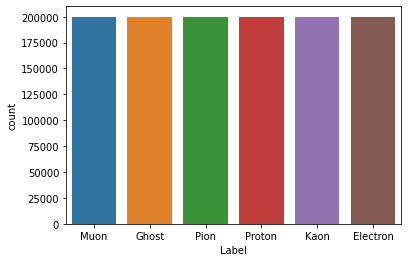

In [34]:
sns.countplot(x = 'Label', data = data)

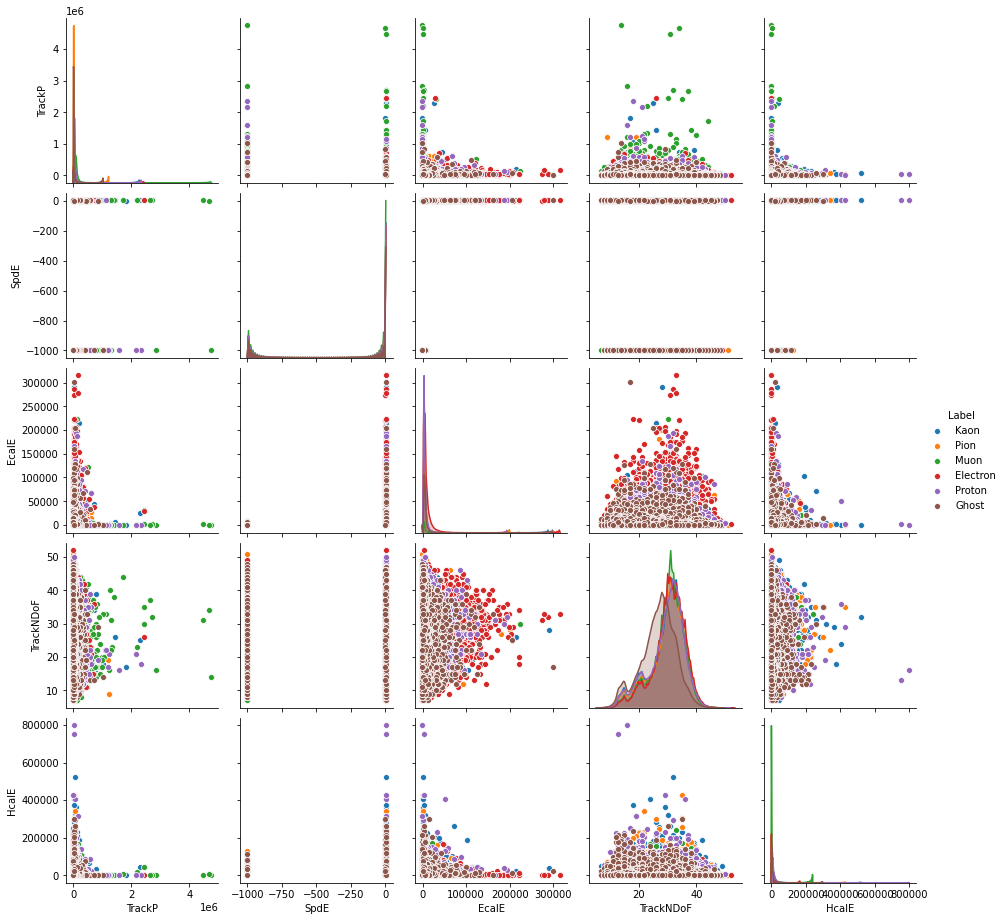

In [24]:
cols1 = ['TrackP', 'SpdE', 'EcalE', 'TrackNDoF', 'HcalE', 'Label']
sns.pairplot(data[cols1].sample(10**6), hue = 'Label',)

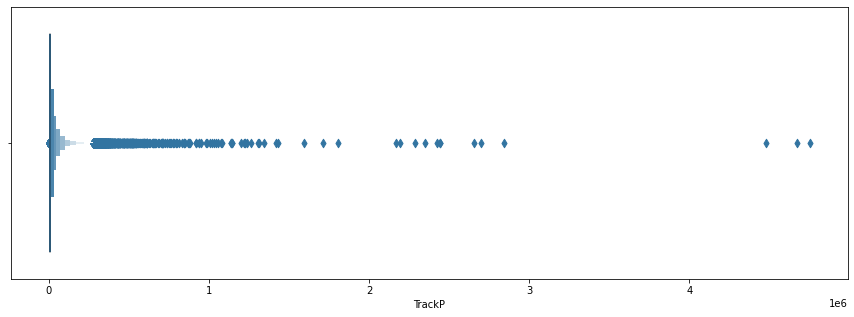

In [38]:
plt.subplots(figsize = (15, 5))
sns.boxenplot(data['TrackP'])
plt.show()

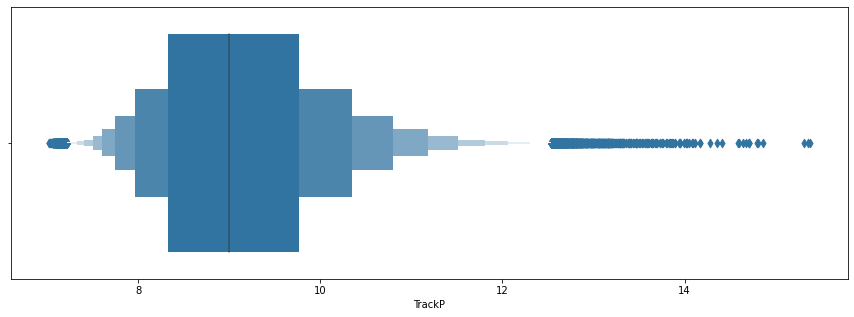

In [11]:
plt.subplots(figsize = (15, 5))
sns.boxenplot(np.log(data['TrackP']))
plt.show()

# Data Preprocessing

*  Binning **TrackP**
*  Label encode the target variable.
*  Test-Train Split

In [24]:
BINS_NUM = 10
lb_encoder = LabelEncoder()
data['iLabel'] = lb_encoder.fit_transform(data['Label'])
#data['log_TrackP'] = np.log(data['TrackP'])
data['binned_P'] = pd.qcut(data['TrackP'], q = BINS_NUM, labels=range(0, BINS_NUM))

features = list(set(data.columns.values) - {'Label', 'iLabel', 'binned_P'})
X = data[features]
y = data['iLabel']
adv_y = data['binned_P']

X_tr, X_val, y_tr, y_val, adv_y_tr, adv_y_val = train_test_split(X, y, adv_y, train_size = 0.85, shuffle = True, stratify = y)

print('X_tr, y_tr, adv_y_tr:\t\t', X_tr.shape, y_tr.shape, adv_y_tr.shape)
print('X_val, y_val, adv_y_val:\t', X_val.shape, y_val.shape, adv_y_val.shape)

X_tr, y_tr, adv_y_tr:		 (1020000, 49) (1020000,) (1020000,)
X_val, y_val, adv_y_val:	 (180000, 49) (180000,) (180000,)


*  Data Normalization (values are centered around 0 with std = 1)

In [25]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_tr)
X_tr_scaled = min_max_scaler.transform(X_tr)
X_val_scaled = min_max_scaler.transform(X_val)

standard_scaler = StandardScaler(with_std = False)
standard_scaler.fit(X_tr_scaled)

X_tr_scaled = standard_scaler.transform(X_tr_scaled)
X_val_scaled = standard_scaler.transform(X_val_scaled)

In [7]:
BATCH_SIZE = 1024

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_tr_scaled, y_tr)).cache().batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val)).batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

X_exp, y_exp = next(iter(train_ds))
X_exp.shape, y_exp.shape

(TensorShape([1024, 49]), TensorShape([1024]))

# Util Functions
https://github.com/hse-aml/hadron-collider-machine-learning/tree/master/week2

In [9]:
def plot_roc_curves(y, y_pred):
  plt.figure(figsize=(8, 5))
  for lb in lb_encoder.classes_:
    label = lb_encoder.transform([lb])[0]
    
    y_true = y == label
    y_hat = y_pred[:, label]

    fpr, tpr, _ = roc_curve(y_true, y_hat)
    auc = roc_auc_score(y_true, y_hat)
    
    particle_name = '{}, AUC = {:.4f}'.format(lb, auc)

    plt.plot(tpr, 1 - fpr, label = particle_name, )
    plt.xlabel('Signal efficiency (TPR)', size=15)
    plt.ylabel("Background rejection (1 - FPR)", size=15)
    plt.xlim(0., 1)
    plt.ylim(0., 1)
    plt.legend(loc='lower left', fontsize=15)
    plt.title('One particle vs rest ROC curves', loc='right', size=15)
    plt.grid(b=1)

def my_percentile(arr, w, q):
    left = 0.
    right = (w).sum()
    sort_inds = np.argsort(arr, axis=0)
    if left/right >= q/100.:
        return arr[0]
    for i in sort_inds:
        left += w[i]
        if left/right >= q/100.:
            return arr[i]

def base_plot(
    prediction, spectator, cut, percentile=True, weights=None, 
    bins_num=100, color='b', marker='o', ms=4, label="MVA", fmt='o', 
    markeredgecolor='b', markeredgewidth=2, ecolor='b'
    ):
  
    if weights is None:
        weights = np.ones(len(prediction))

    if percentile:
        if weights is None:
            cut = np.percentile(prediction, 100-cut)
        else:
            cut = my_percentile(prediction, weights, 100-cut)
    
    edges = np.linspace(spectator.min(), spectator.max(), bins_num)
    
    xx = []
    yy = []
    xx_err = []
    yy_err = []
    
    for i_edge in range(len(edges)-1):
        left = edges[i_edge]
        right = edges[i_edge + 1]
        
        N_tot_bin = weights[((spectator >= left) * (spectator < right))].sum()
        N_cut_bin = weights[((spectator >= left) * (spectator < right) * (prediction >= cut))].sum()
        
        if N_tot_bin != 0:
            x = 0.5 * (right + left)
            y = 1. * N_cut_bin / N_tot_bin
            
            if y > 1.:
                y = 1.
            if y < 0:
                y = 0
            
            xx.append(x)
            yy.append(y)
            
            x_err = 0.5 * (right - left)
            y_err = np.sqrt(y*(1-y)/N_tot_bin)
            
            xx_err.append(x_err)
            yy_err.append(y_err)
        
        else:
            pass

    plt.errorbar(
        xx, yy, yerr=yy_err, xerr=xx_err, fmt=fmt, color=color, marker=marker, 
        ms=ms, label=label, markeredgecolor=markeredgecolor, 
        markeredgewidth=markeredgewidth, ecolor=ecolor
    )
    return cut

def plot_efficiency(preds, labels, spectator, threshold=60, bins_num=20, xlabel='Spectator'):
    plt.figure(figsize=(5.5*2, 3.5*3))
    u_labels = np.unique(labels)
    for lab in u_labels:
        y_true = labels == lab
        pred = preds[y_true, lab]
        spec = spectator[y_true]
        plt.subplot(3, 2, lab+1)
        base_plot(
            pred, spec, cut=threshold, percentile=True, weights=None, 
            bins_num=bins_num, color='1', marker='o', fmt='o', ms=7,
            label=lb_encoder.inverse_transform([lab])[0],
        )
        
        plt.plot(
            [spec.min(), spec.max()], 
            [threshold / 100., threshold / 100.], 
            label='Global signal efficiecny', color='r', linewidth=3
        )
        plt.legend(loc='best', fontsize=12)
        plt.xticks(size=12)
        plt.yticks(size=12)
        plt.ylabel('Signal efficiency (TPR)', size=12)
        plt.xlabel(xlabel,size=12)
        plt.ylim(0, 1)
        plt.xlim(spec.min(), spec.max())
        plt.grid(b=1)
    plt.tight_layout()

def plot_efficiency_wtr_momentum(preds, labels, spectator, threshold = 60, bins_num = 20):
  selector = spectator < 200 * 10 ** 3
  plot_efficiency(preds[selector], labels[selector], spectator[selector] / 10**3, threshold, bins_num, 'Momentum, GeV/c')


# Classifier without Adversary

## Model Definition & Training

In [119]:
def create_model():
  model = Sequential()
  model.add(Dense(512, activation = 'relu', dtype = tf.float32),)
  model.add(Dropout(0.1))
  model.add(Dense(6, activation = 'softmax', dtype = tf.float32),)
  model.compile(loss = SparseCategoricalCrossentropy(), optimizer = Adam(1e-3))
  return model

cls_model = create_model()
cls_model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 100,
    verbose = 1,
)

Epoch 1/100
997/997 [==============================] - 13s 13ms/step - loss: 0.9105 - val_loss: 0.7305
Epoch 2/100
997/997 [==============================] - 13s 13ms/step - loss: 0.7015 - val_loss: 0.6679
Epoch 3/100
997/997 [==============================] - 13s 13ms/step - loss: 0.6619 - val_loss: 0.6451
Epoch 4/100
997/997 [==============================] - 13s 13ms/step - loss: 0.6444 - val_loss: 0.6330
Epoch 5/100
997/997 [==============================] - 13s 13ms/step - loss: 0.6347 - val_loss: 0.6257
Epoch 6/100
997/997 [==============================] - 13s 13ms/step - loss: 0.6282 - val_loss: 0.6212
Epoch 7/100
997/997 [==============================] - 13s 13ms/step - loss: 0.6234 - val_loss: 0.6171
Epoch 8/100
997/997 [==============================] - 13s 13ms/step - loss: 0.6197 - val_loss: 0.6141
Epoch 9/100
997/997 [==============================] - 13s 13ms/step - loss: 0.6167 - val_loss: 0.6120
Epoch 10/100
997/997 [==============================] - 13s 13ms/step - l

## Model Evaluation

In [120]:
y_val_pred = cls_model.predict(X_val_scaled)
print('validation error: {:.4f} \n'.format(log_loss(y_val, y_val_pred)))

class_names = lb_encoder.classes_
y_val_hat = np.argmax(y_val_pred, axis = -1)
print(classification_report(y_val, y_val_hat, target_names=class_names, digits = 2))

validation error: 0.5748 

              precision    recall  f1-score   support

    Electron       0.88      0.89      0.88     30000
       Ghost       0.76      0.80      0.78     30000
        Kaon       0.67      0.55      0.60     30000
        Muon       0.91      0.91      0.91     30000
        Pion       0.71      0.80      0.75     30000
      Proton       0.64      0.62      0.63     30000

    accuracy                           0.76    180000
   macro avg       0.76      0.76      0.76    180000
weighted avg       0.76      0.76      0.76    180000



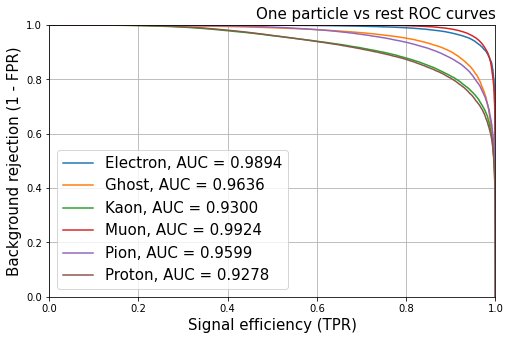

In [121]:
plot_roc_curves(y_val, y_val_pred)

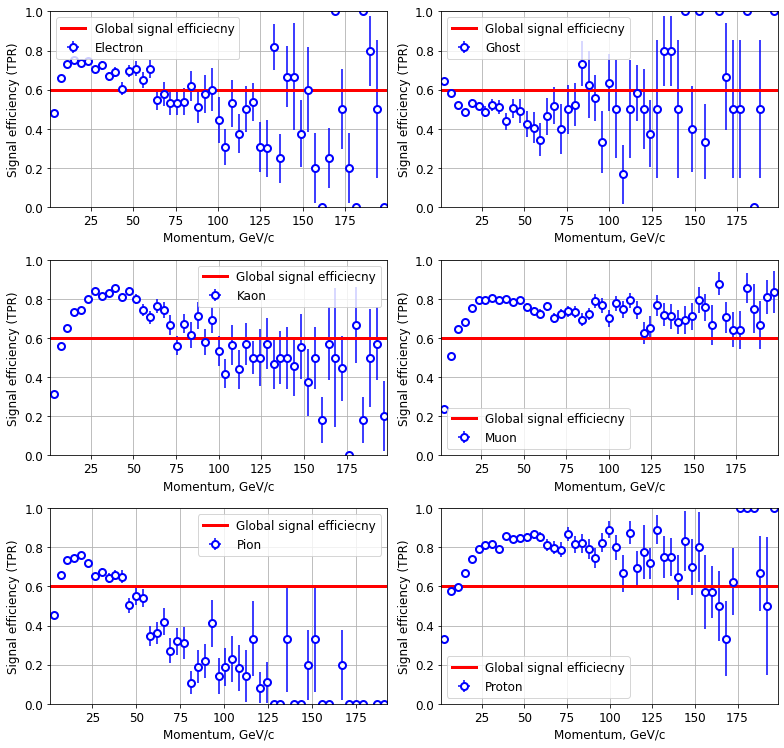

In [122]:
plot_efficiency_wtr_momentum(y_val_pred, y_val, X_val['TrackP'].values, 60, 50)
plt.show()

# Classifier-Adversary

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((X_tr_scaled, y_tr, adv_y_tr)).cache().batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val, adv_y_val)).batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

X_exp, y_exp, adv_y_exp = next(iter(train_ds))
X_exp.shape, y_exp.shape, adv_y_exp.shape

(TensorShape([1024, 49]), TensorShape([1024]), TensorShape([1024]))

## Classifier Definition

In [11]:
def create_classifier():
  model = Sequential()
  model.add(Dense(512, activation = 'relu', dtype = tf.float32))
  model.add(Dropout(0.1))
  model.add(Dense(6, dtype = tf.float32))
  return model

classifier = create_classifier()
cls_output = classifier(X_exp, training = False)
cls_output.shape

TensorShape([1024, 6])

## Adversary Definition

In [27]:
def create_adversary():
  model = Sequential()
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.1))
  model.add(Dense(BINS_NUM))
  return model

adversary = create_adversary()
adv_output = adversary(cls_output, training = False)
adv_output.shape

TensorShape([1024, 10])

## Loss Functions & Optimizers

In [45]:
cross_entropy = SparseCategoricalCrossentropy(from_logits = True)
def classifier_loss(y_true, y_hat):
  return cross_entropy(y_true, y_hat)

def adversary_loss(y_true, y_hat):
  return cross_entropy(y_true, y_hat)

def classifier_adversary_loss(cls_loss, adv_loss, lambd = 0.1):
  return cls_loss - lambd * adv_loss

cls_optimizer = Adam(1e-3)
adv_optimizer = Adam(1e-3)

## Save Checkpoints

In [29]:
ckpt_dir = 'training_checkpoints'
ckpt_prefix = os.path.join(ckpt_dir, 'ckpt')
checkpoint = Checkpoint(
    cls_optimizer = cls_optimizer, 
    adv_optimizer = adv_optimizer,
    classifier = classifier, 
    adversary = adversary
)

## Metrics

In [30]:
cls_acc = SparseCategoricalAccuracy(name = 'cls_acc',)
cls_error = Mean(name = 'cls_error')

adv_acc = SparseCategoricalAccuracy(name = 'adv_acc',)
adv_error = Mean(name = 'adv_error')

def reset_metrics():
  cls_acc.reset_states()
  cls_error.reset_states()
  adv_acc.reset_states()
  adv_error.reset_states()

## Training Loop

In [46]:
!rm -R training_checkpoints

In [47]:
EPOCHS = 100
classifier = create_classifier()
adversary = create_adversary()

@tf.function
def train_step(cls_X, cls_y_true, adv_y_true, epoch):
  with tf.GradientTape() as cls_tape, tf.GradientTape() as adv_tape:
    cls_y_hat = classifier(cls_X, training = True)
    adv_y_hat = adversary(cls_y_hat, training = True)

    cls_loss = classifier_loss(cls_y_true, cls_y_hat)
    adv_loss = adversary_loss(adv_y_true, adv_y_hat)
    cls_adv_loss = classifier_adversary_loss(cls_loss, adv_loss)
  
  adv_vars = adversary.trainable_variables
  adv_grads = adv_tape.gradient(adv_loss, adv_vars)
  adv_optimizer.apply_gradients(zip(adv_grads, adv_vars))

  cls_vars = classifier.trainable_variables
  cls_grads = cls_tape.gradient(cls_adv_loss, cls_vars)
  cls_optimizer.apply_gradients(zip(cls_grads, cls_vars))

  cls_acc(cls_y_true, cls_y_hat)
  cls_error(cls_loss)
  adv_acc(adv_y_true, adv_y_hat)
  adv_error(adv_loss)

for epoch in range(1, EPOCHS + 1):
  start = time.time()
  reset_metrics()
  for batch, (cls_X, cls_y, adv_y) in enumerate(train_ds):
    train_step(cls_X, cls_y, adv_y, epoch)
    if batch % 500 == 0:
      msg = 'Epoch {}, Batch {},\t cls_loss {:.4f}, cls_acc {:.2f}, adv_loss {:.4f}, adv_acc {:.2f}'.format(
          epoch, batch, cls_error.result(), cls_acc.result(), adv_error.result(), adv_acc.result()
      )
      print(msg)
  if epoch % 5 == 0:
    checkpoint.save(ckpt_prefix)
  print ('Time for epoch {} is {:.2f} sec\n'.format(epoch, time.time()-start))

Epoch 1, Batch 0,	 cls_loss 1.7952, cls_acc 0.16, adv_loss 2.3032, adv_acc 0.08
Epoch 1, Batch 500,	 cls_loss 1.0519, cls_acc 0.60, adv_loss 2.0477, adv_acc 0.24
Time for epoch 1 is 3.14 sec

Epoch 2, Batch 0,	 cls_loss 0.7969, cls_acc 0.69, adv_loss 2.0181, adv_acc 0.26
Epoch 2, Batch 500,	 cls_loss 0.7324, cls_acc 0.71, adv_loss 2.0030, adv_acc 0.25
Time for epoch 2 is 2.58 sec

Epoch 3, Batch 0,	 cls_loss 0.7300, cls_acc 0.72, adv_loss 1.9733, adv_acc 0.27
Epoch 3, Batch 500,	 cls_loss 0.6851, cls_acc 0.73, adv_loss 1.9940, adv_acc 0.26
Time for epoch 3 is 2.56 sec

Epoch 4, Batch 0,	 cls_loss 0.6977, cls_acc 0.72, adv_loss 1.9412, adv_acc 0.28
Epoch 4, Batch 500,	 cls_loss 0.6638, cls_acc 0.74, adv_loss 1.9934, adv_acc 0.26
Time for epoch 4 is 2.68 sec

Epoch 5, Batch 0,	 cls_loss 0.6825, cls_acc 0.73, adv_loss 1.9462, adv_acc 0.28
Epoch 5, Batch 500,	 cls_loss 0.6517, cls_acc 0.74, adv_loss 1.9902, adv_acc 0.26
Time for epoch 5 is 2.65 sec

Epoch 6, Batch 0,	 cls_loss 0.6811, cls_

## Evaluation

In [48]:
y_val_pred = classifier.predict(X_val_scaled)
print('validation error: {:.4f} \n'.format(log_loss(y_val, y_val_pred)))

class_names = lb_encoder.classes_
y_val_hat = np.argmax(y_val_pred, axis = -1)
print(classification_report(y_val, y_val_hat, target_names=class_names, digits = 2))

validation error: 1.7602 

              precision    recall  f1-score   support

    Electron       0.89      0.87      0.88     30000
       Ghost       0.75      0.81      0.78     30000
        Kaon       0.65      0.59      0.62     30000
        Muon       0.91      0.91      0.91     30000
        Pion       0.70      0.80      0.75     30000
      Proton       0.65      0.60      0.62     30000

    accuracy                           0.76    180000
   macro avg       0.76      0.76      0.76    180000
weighted avg       0.76      0.76      0.76    180000



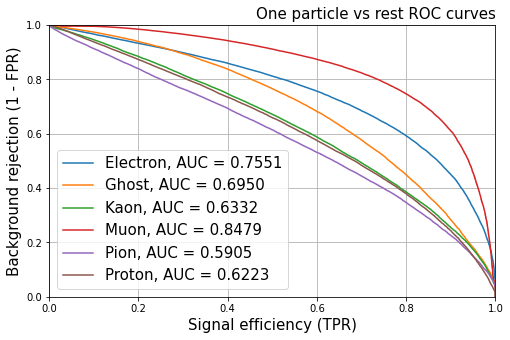

In [49]:
plot_roc_curves(y_val, y_val_pred)

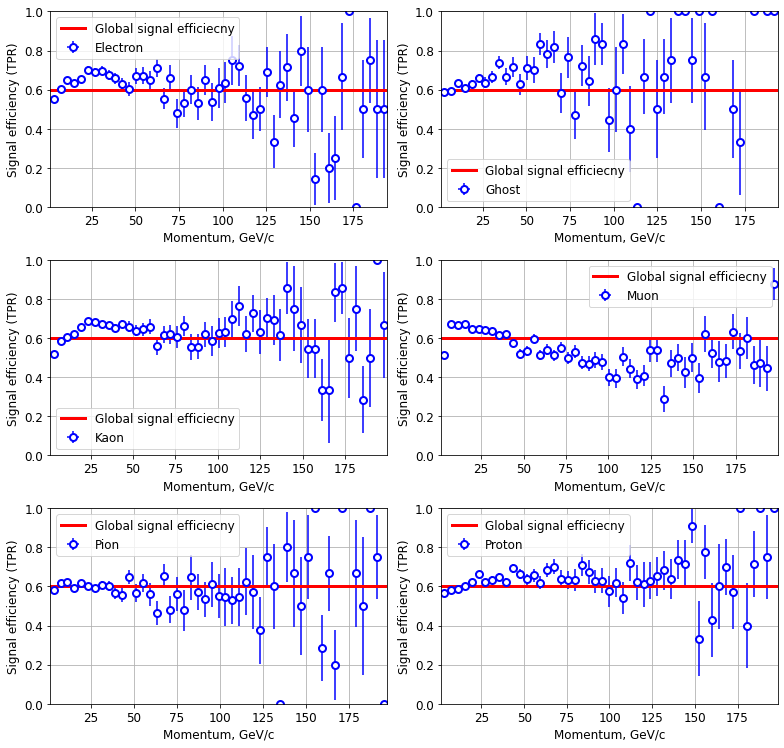

In [50]:
plot_efficiency_wtr_momentum(y_val_pred, y_val, X_val['TrackP'].values, 60, 50)
plt.show()